In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
except:
    print("Mounting Failed.")
sys.path.insert(1, './gdrive/MyDrive/ProjectDL/AutoSpikeEncoder-sl-unified')

In [1]:

import os
#os.chdir("/content")
## External Libraries
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
!pip install scikit-learn==0.24.1
from sklearn.mixture import GaussianMixture
!pip install graspologic
from graspologic.utils import remap_labels
from graspologic.cluster import AutoGMMCluster
import seaborn as sns
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
sns.set_theme()
sns.set_context("paper")



In [2]:
from end2end import End2End
from datasets import UnsupervisedDataset, SupervisedDataset, BenchmarkDataset
from matplotlib import pyplot as plt
import pickle

In [3]:
data_dir = "./data/pedreira"
results_dir = "./local/e2e_res"

In [4]:
#Model has been trained locally for speed on pedreira session 12
#Now load model
with open('./local/e2e_sim_s10_forceloss.pkl', 'rb') as f:
    e2e = pickle.load(f)

In [5]:
sup_data = BenchmarkDataset(data_dir, input_dim=39)
train_data = sup_data[10]
test_data = sup_data[10]

In [16]:
#@title Accuracy etc. functions
def gt_gmm(latent_vecs, test_targets):
    test_acc = []
    test_prec = []
    test_recall = []
    session_weights = []
    remapped_preds = []
    for (i, latent), targets in zip(enumerate(latent_vecs), test_targets):
        session_weights.append(len(targets))
        units = set(targets)
        num_units = len(units)
        gmm = GaussianMixture(n_components=num_units)
        pred = gmm.fit_predict(latent)
        remapped_pred = remap_labels(targets, pred)
        remapped_preds.append(remapped_pred)
        prec = []
        recall = []
        for unit in units:
            TP = np.sum(np.logical_and(remapped_pred==unit, targets==unit))
            FP = np.sum(np.logical_and(remapped_pred==unit, targets!=unit))
            if FP == 0:
                prec.append(1)
            else:
                prec.append(TP / (TP + FP))
            TN = np.sum(np.logical_and(remapped_pred!=unit, targets!=unit))
            FN = np.sum(np.logical_and(remapped_pred!=unit, targets==unit))
            if FN == 0:
                recall.append(1)
            else:
                recall.append(TP / (TP + FN))

        test_prec.append(np.mean(prec))
        test_recall.append(np.mean(recall))
        test_acc.append(sum(remapped_pred==targets)/len(targets))

    session_weights = np.array(session_weights) / sum(session_weights)
    avg_acc = np.sum(test_acc*session_weights)
    avg_prec = np.mean(test_prec)
    avg_recall = np.mean(test_recall)
    avg_stats = avg_acc, avg_prec, avg_recall
    session_stats = test_acc, test_prec, test_recall
    return avg_stats, session_stats, remapped_preds

def auto_gmm(latent_vecs, test_targets):
    test_acc = []
    test_prec = []
    test_recall = []
    session_weights = []
    remapped_preds = []
    max_n_comps = 21
    for (i, latent), targets in zip(enumerate(latent_vecs), test_targets):
        session_weights.append(len(targets))
        units = set(targets)
        num_units = len(units)
        bics = []
        preds = []
        for n_comps in range(1, max_n_comps+1):
            gmm = GaussianMixture(n_components=n_comps)
            preds.append(gmm.fit_predict(latent))
            bics.append(gmm.bic(latent))
        pred = preds[np.argmin(bics)]
        print("predicted num_units=", np.argmin(bics)+1)
        print("true num_units=", num_units)
        remapped_pred = remap_labels(targets, pred)
        remapped_preds.append(remapped_pred)
        prec = []
        recall = []
        for unit in units:
            TP = np.sum(np.logical_and(remapped_pred==unit, targets==unit))
            FP = np.sum(np.logical_and(remapped_pred==unit, targets!=unit))
            if FP == 0:
                prec.append(1)
            else:
                prec.append(TP / (TP + FP))
            TN = np.sum(np.logical_and(remapped_pred!=unit, targets!=unit))
            FN = np.sum(np.logical_and(remapped_pred!=unit, targets==unit))
            if FN == 0:
                recall.append(1)
            else:
                recall.append(TP / (TP + FN))

        test_prec.append(np.mean(prec))
        test_recall.append(np.mean(recall))
        test_acc.append(sum(remapped_pred==targets)/len(targets))

    session_weights = np.array(session_weights) / sum(session_weights)
    avg_acc = np.sum(test_acc*session_weights)
    avg_prec = np.mean(test_acc)
    avg_recall = np.mean(test_recall)
    avg_stats = avg_acc, avg_prec, avg_recall
    session_stats = test_acc, test_prec, test_recall
    return avg_stats, session_stats, remapped_preds

def viz_stats(avg_stats, session_stats, _title, figname):
    avg_acc, avg_prec, avg_recall = avg_stats
    test_acc, test_prec, test_recall = session_stats
    print("Average Accuracy=", avg_acc)
    print("Average Precision=", avg_prec)
    print("Average Recall=", avg_recall)

    fig = plt.figure()
    plt.hold = True
    plt.plot(np.arange(1, 21, 2), test_acc, label="Accuracy")
    plt.plot(np.arange(1, 21, 2), test_prec, label="Precision")
    plt.plot(np.arange(1, 21, 2), test_recall, label="Recall")
    plt.hold = False
    plt.legend()
    plt.xlabel("True Number of Units (before SNR)")
    plt.ylabel("Performance")
    plt.title(_title)
    plt.savefig(results_dir+"/"+figname)

def viz_tsne(unit_nums, latent_vecs, test_targets, remapped_preds, fignames):
    for idx, figname in zip(unit_nums, fignames):
        i = idx - 2 #accounting for offset since idx=0 has 2 units
        latent = latent_vecs[i]
        targets = test_targets[i]
        remapped_pred = remapped_preds[i]

        # Plot tsne
        latent_manifold = tsne.fit_transform(latent)

        fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
        ax1.set_title("Ground Truth Labels")
        ax1.set_xticks([])
        ax1.set_yticks([])
        for c in range(np.max(targets)+1):
            c_manifold = latent_manifold[targets == c]
            ax1.scatter(c_manifold[:, 0], c_manifold[:, 1], marker=".", s=.5)

        ax2.set_title("Predicted Labels")
        for c in range(np.max(remapped_pred)+1):
            c_manifold = latent_manifold[remapped_pred == c]
            ax2.scatter(c_manifold[:, 0], c_manifold[:, 1], marker=".", s=.5)
        plt.savefig(results_dir+"/"+figname)
        break

def embed_test(test_data, e2e):
    latent_vecs = []
    test_targets = []
    for spikes, targets, snrs, num_units in [test_data]:
        session_latent = []
        ks, bics = e2e.bics(spikes)
        possible_targets = np.arange(len(snrs))
        hi_fidel_targets = possible_targets[snrs>=min_snr]
        spikes = torch.FloatTensor(spikes[np.isin(targets, hi_fidel_targets)])
        session_targets = targets[np.isin(targets, hi_fidel_targets)]
        #if "cuda" in e2e.device:
        #    spikes = spikes.cuda(0)
        #for encoder in ae.encoders:
        #    session_latent.append(encoder(spikes))
        #session_latent = torch.cat(session_latent, dim=1).detach().cpu()
        _ , _, session_latent = e2e.predict(spikes, ks[np.argmin(bics)], return_latent=True)
        latent_vecs.append(session_latent)
        test_targets.append(session_targets)
    return latent_vecs, test_targets

min_snr= 0
(0.8048992123881992, 0.770645759145958, 0.7950525047643036)
([0.8048992123881992], [0.770645759145958], [0.7950525047643036])
predicted num_units= 20
true num_units= 21
min_snr= 4
(0.8701542479392802, 0.8542853479983566, 0.7879349038283208)
([0.8701542479392802], [0.8542853479983566], [0.7879349038283208])
predicted num_units= 21
true num_units= 20
min_snr= 8
(0.8597062013211082, 0.9304772414736215, 0.8267984710733028)
([0.8597062013211082], [0.9304772414736215], [0.8267984710733028])
predicted num_units= 17
true num_units= 17
min_snr= 10
(0.8231318541188473, 0.8387728337861015, 0.7702486505538739)
([0.8231318541188473], [0.8387728337861015], [0.7702486505538739])
predicted num_units= 12
true num_units= 12


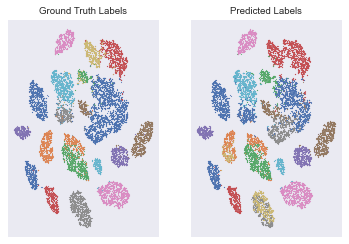

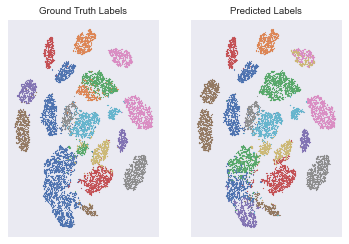

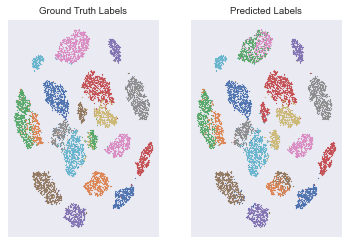

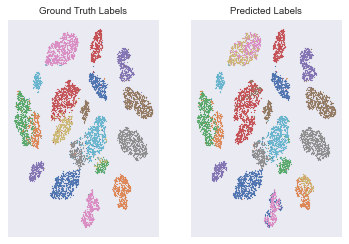

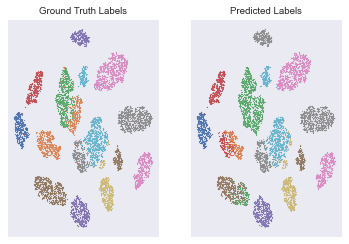

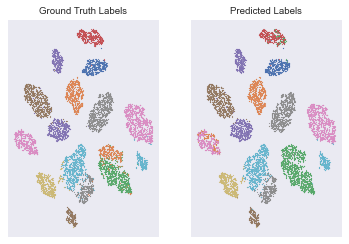

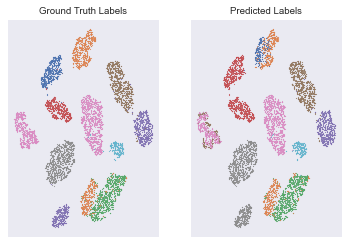

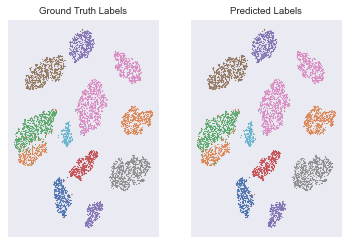

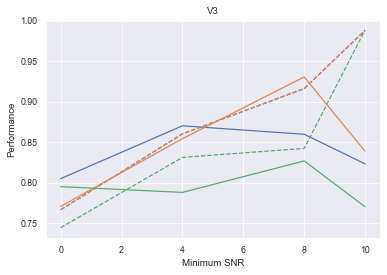

In [22]:
min_snrs = [0, 4, 8, 10]
ae_is_trained = [False, False, False, False] #whether the autoencoder is already trained on the corresponding snr



#Eval Loop
snr_acc, snr_prec, snr_recall = [], [], []
for min_snr, is_trained in zip(min_snrs, ae_is_trained):
    print("min_snr=", min_snr)
    prefix="benchmark_snr_%s"%min_snrs[0]
    latent_vecs, test_targets = embed_test(test_data, e2e)
    
    avg_stats, session_stats, remapped_preds = gt_gmm(latent_vecs, test_targets)
    acc, prec, recall = avg_stats
    accs, precs, recalls = [], [], []
    accs.append(acc)
    precs.append(prec)
    recalls.append(recall)
    print(avg_stats)
    print(session_stats)
    #viz_stats(avg_stats, session_stats, "Ground-Truth GMM: minimum SNR=%s"%min_snr, "gtgmm_stats_snr%s"%min_snr)
    fignames = ["gtgmm_tsne_snr%s_numunits%s"%(min_snr, n) for n in [2, 10, 20]]
    viz_tsne([2, 10, 20], latent_vecs, test_targets, remapped_preds, fignames)

    avg_stats, session_stats, remapped_preds = auto_gmm(latent_vecs, test_targets)
    acc, prec, recall = avg_stats
    accs.append(acc)
    precs.append(prec)
    recalls.append(recall)
    #viz_stats(avg_stats, session_stats, "Auto GMM: minimum SNR=%s"%min_snr, "autogmm_stats_snr%s"%min_snr)
    fignames = ["autogmm_tsne_snr%s_numunits%s"%(min_snr, n) for n in [2, 10, 20]]
    viz_tsne([2, 10, 20], latent_vecs, test_targets, remapped_preds, fignames)

    snr_acc.append(accs)
    snr_prec.append(precs)
    snr_recall.append(recalls)

snr_acc = np.array(snr_acc)
np.save(results_dir+"/snr_acc.npy", snr_acc)
snr_prec = np.array(snr_prec)
np.save(results_dir+"/snr_prec.npy", snr_prec)
snr_recall = np.array(snr_recall)
np.save(results_dir+"/snr_recall.npy", snr_recall)
plt.figure()
plt.hold = True
plt.plot(min_snrs, snr_acc[:, 0], label="Average Accuracy", c="C0", ls="-")
plt.plot(min_snrs, snr_acc[:, 1], c="C0", ls="--")
plt.plot(min_snrs, snr_prec[:, 0], label="Average Precision", c="C1", ls="-")
plt.plot(min_snrs, snr_prec[:, 1], c="C1", ls="--")
plt.plot(min_snrs, snr_recall[:, 0], label="Average Recall", c="C2", ls="-")
plt.plot(min_snrs, snr_recall[:, 1], c="C2", ls="--")
plt.hold = False
plt.xlabel("Minimum SNR")
plt.ylabel("Performance")
plt.title("V3")
plt.savefig(results_dir+"/v3_snr_stats")